# 目的
LightGBMによる特徴量を追加する、Spacy TokenでのCVを計算する。

In [3]:
SEED = 42

In [4]:
id2label = {
    0: "O",
    1: "B-NAME_STUDENT",
    2: "I-NAME_STUDENT",
    3: "B-EMAIL",
    4: "I-EMAIL",
    5: "B-USERNAME",
    6: "I-USERNAME",
    7: "B-ID_NUM",
    8: "I-ID_NUM",
    9: "B-PHONE_NUM",
    10: "I-PHONE_NUM",
    11: "B-URL_PERSONAL",
    12: "I-URL_PERSONAL",
    13: "B-STREET_ADDRESS",
    14: "I-STREET_ADDRESS",
}

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold

from datasets import load_from_disk
from datasets.arrow_dataset import Dataset

In [4]:
valid_dataset = load_from_disk("/kaggle/input/pii-valid-dataset")

# 直接読んでしまうと、
# OSError: [Errno 30] Read-only file system: '/kaggle/input/e083-original-data-mpware-deberta-v3-large/valid_dataset/tmpu2p70cd5'
# が発生する
valid_dataset.save_to_disk("valid_dataset")
valid_dataset = load_from_disk("valid_dataset")

valid_dataset

Saving the dataset (0/1 shards):   0%|          | 0/473 [00:00<?, ? examples/s]

Dataset({
    features: ['full_text', 'trailing_whitespace', 'provided_labels', 'tokens', 'document', 'flag', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'length', 'token_map'],
    num_rows: 473
})

In [5]:
# valid　dataを読み込む
with open("/kaggle/input/make-valid-data/valid-pred-e072-fix-tokenize-deberta-v3-large.npy", "rb") as f:
    valid_e072 = np.load(f)

with open("/kaggle/input/make-valid-data/valid-pred-e078-public-high-deberta-v3-large-retry2.npy", "rb") as f:
    valid_e078 = np.load(f)
    
with open("/kaggle/input/make-valid-data/valid-pred-e083-original-data-mpware-deberta-v3-large.npy", "rb") as f:
    valid_e083 = np.load(f)

In [6]:
# subしている手法でensembleする。今回はaverageとする
weights = [0.964, 0.941, 0.960] # average
weights_probs = [w / sum(weights) for w in weights]

valid_preds = weights_probs[0] * valid_e072 \
            + weights_probs[1] * valid_e078 \
            + weights_probs[2] * valid_e083

In [7]:
TAG_NAMES = [
    "O",
    "B-NAME_STUDENT",
    "I-NAME_STUDENT",
    "B-EMAIL",
    "I-EMAIL",
    "B-USERNAME",
    "I-USERNAME",
    "B-ID_NUM",
    "I-ID_NUM",
    "B-PHONE_NUM",
    "I-PHONE_NUM",
    "B-URL_PERSONAL",
    "I-URL_PERSONAL",
    "B-STREET_ADDRESS",
    "I-STREET_ADDRESS",
]

In [8]:
def preds_to_df(preds: list[np.ndarray]) -> list[pd.DataFrame]:
    """各テキストごとに、pd.DataFrameへ変換する"""
    return [
        pd.DataFrame(
            pred, 
            columns=TAG_NAMES
        )
        for pred
        in preds
    ]

class MakeShiftFeat:
    def __init__(self, org_df: pd.DataFrame) -> None:
        self.org_df = org_df.copy()
    def make_shift_feat(self, df: pd.DataFrame, shift_num: int) -> pd.DataFrame:
        if shift_num > 0:
            df.loc[:,[f"prev_{shift_num}_{col}" for col in TAG_NAMES]] = self.org_df.shift(shift_num).values
        elif shift_num < 0:
            df.loc[:,[f"future_{abs(shift_num)}_{col}" for col in TAG_NAMES]] = self.org_df.shift(shift_num).values
        else:
            raise Exception("0に意味はありません。")
        return df

def make_feature_df_per_text(
    input_len: int,
    pred_df: pd.DataFrame,
    document: str | None,
    labels: list[int] | None
) -> pd.DataFrame:
    """テキストごとに特徴量の生成を行う
    NOTE: テキストの　DataFrameごとに生成をしないと、テキストをまたぐ際に別のテキストの情報を使ってしまうため注意
    """
    
    # 与えられたinputの長さ以上はpaddingを行なっているため、捨てる
    # NOTE: 特徴量エンジニアリングよりも先にやらないと、paddingの値を特徴量として持ってしまう
    pred_df = pred_df.iloc[:input_len, :]
    
    # 特徴量エンジニアリングを行う。 # 
    MSF = MakeShiftFeat(pred_df)
    
    # 自分より前の推論確率を加える
    pred_df = MSF.make_shift_feat(pred_df, 1)
    # pred_df = MSF.make_shift_feat(pred_df, 2)
    # pred_df = MSF.make_shift_feat(pred_df, 3)
    
    # 自分より後の推論確率を加える
    pred_df = MSF.make_shift_feat(pred_df, -1)
    # pred_df = MSF.make_shift_feat(pred_df, -2)
    # pred_df = MSF.make_shift_feat(pred_df, -3)
    
    if labels:
        # 正解のlabel列を加える
        pred_df.loc[:, ["labels"]] = labels
    
    if document:
        # documentを加える
        pred_df.loc[:, ["document"]] = document
    
    return pred_df

def make_valid_feature_df(
    valid_dataset: Dataset,
    valid_pred_dfs: list[pd.DataFrame]
) -> pd.DataFrame:
    return pd.concat(
        [
            make_feature_df_per_text(len(input_ids), valid_pred_df, document, labels)
            for document, labels, input_ids, valid_pred_df
            in zip(
                valid_dataset["document"],
                valid_dataset["labels"],
                valid_dataset["input_ids"],
                valid_pred_dfs
            )
        ]
    ).reset_index(drop=True)

valid_pred_dfs = preds_to_df(valid_preds)
valid_feature_df = make_valid_feature_df(valid_dataset, valid_pred_dfs)

In [9]:
# 確認
assert valid_feature_df.iloc[1]["prev_1_O"] == valid_feature_df.iloc[0]["O"] # prev_1_Oは1つ前のOの値
assert valid_feature_df.iloc[0]["future_1_O"] == valid_feature_df.iloc[1]["O"] # future_1_Oは1つ後のOの値
assert np.isnan(valid_feature_df.iloc[0]["prev_1_O"]) # prev_1_Oは最初がnan
assert np.isnan(valid_feature_df.iloc[1016]["future_1_O"]) # future_1_Oは最後がnan

assert valid_feature_df["document"].nunique() == 473 # documentのunique数はvalid_datasetと同じはず

In [10]:
# パターンを付与する
import json
with open("/kaggle/input/pii-document-pattern-dict-json/document_pattern_dict.json", "rb") as f:
    document_pattern_dict = json.load(f)
    
valid_feature_df["pattern"] = valid_feature_df["document"].map(document_pattern_dict)

In [11]:
# train, validを半分に分ける
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=False)

group = valid_feature_df["pattern"]

for i, (train_index, test_index) in enumerate(sgkf.split(
        valid_feature_df,
        valid_feature_df["pattern"],
        valid_feature_df["document"]
        )
    ):
    train_df = valid_feature_df.iloc[train_index]
    valid_df = valid_feature_df.iloc[test_index]
    break

In [12]:
train_df["labels"].value_counts()

labels
0     300945
11       788
1        701
2        525
7        142
3         76
10        24
14        12
5          7
9          3
8          3
13         1
Name: count, dtype: int64

In [13]:
# Oのデータを削減する
wo_o_index = train_df[train_df["labels"] != 0].index
o_index = train_df[train_df["labels"] == 0].sample(500).index

use_index = wo_o_index.append(o_index)

train_df = train_df[train_df.index.isin(use_index)]

In [14]:
train_df["labels"].map(id2label).value_counts()

labels
B-URL_PERSONAL      788
B-NAME_STUDENT      701
I-NAME_STUDENT      525
O                   500
B-ID_NUM            142
B-EMAIL              76
I-PHONE_NUM          24
I-STREET_ADDRESS     12
B-USERNAME            7
B-PHONE_NUM           3
I-ID_NUM              3
B-STREET_ADDRESS      1
Name: count, dtype: int64

In [15]:
valid_df["labels"].map(id2label).value_counts()

labels
O                 100824
B-URL_PERSONAL       259
B-NAME_STUDENT       230
I-NAME_STUDENT       200
B-ID_NUM              91
B-EMAIL               48
I-URL_PERSONAL         7
Name: count, dtype: int64

In [16]:
# パターンの割合
print(train_df["pattern"].value_counts(normalize=True).sort_values(ascending=False))
print("")
print(valid_df["pattern"].value_counts(normalize=True).sort_values(ascending=False))

pattern
1_1_0_0_0_0_0_0_0_0_0_0_0_0    0.483465
0_0_0_0_0_0_0_0_0_0_1_0_0_0    0.178289
1_1_0_0_0_0_0_0_0_0_1_0_0_0    0.103163
1_1_0_0_0_0_1_0_0_0_0_0_0_0    0.073329
1_0_0_0_0_0_0_0_0_0_0_0_0_0    0.063264
1_1_1_0_0_0_0_0_0_0_1_0_0_0    0.034867
1_1_1_0_0_0_0_0_0_0_0_0_0_0    0.024443
1_1_1_0_0_0_0_0_1_1_0_0_0_0    0.020489
Other                          0.011143
0_0_0_0_0_0_1_0_0_0_0_0_0_0    0.003235
1_0_0_0_0_0_1_0_0_0_0_0_0_0    0.002157
0_0_0_0_1_0_0_0_0_0_0_0_0_0    0.002157
Name: proportion, dtype: float64

pattern
1_1_0_0_0_0_0_0_0_0_0_0_0_0    0.792493
1_0_0_0_0_0_0_0_0_0_0_0_0_0    0.065838
0_0_0_0_0_0_0_0_0_0_1_0_0_0    0.042849
1_1_0_0_0_0_0_0_0_0_1_0_0_0    0.031458
1_1_0_0_0_0_1_0_0_0_0_0_0_0    0.018985
0_0_0_0_0_0_1_0_0_0_0_0_0_0    0.013840
1_1_1_0_0_0_0_0_0_0_0_0_0_0    0.012375
0_0_1_0_0_0_0_0_0_0_0_0_0_0    0.008381
1_1_1_0_0_0_0_0_0_0_1_0_0_0    0.007328
Other                          0.006453
Name: proportion, dtype: float64


In [17]:
# trainとvalidで共通するdocumentは存在しない
assert not set(train_df["document"]) & set(valid_df["document"])

# 学習

In [18]:
use_col = train_df.columns.tolist()
use_col.remove("labels")
use_col.remove("document")
use_col.remove("pattern")
use_col

['O',
 'B-NAME_STUDENT',
 'I-NAME_STUDENT',
 'B-EMAIL',
 'I-EMAIL',
 'B-USERNAME',
 'I-USERNAME',
 'B-ID_NUM',
 'I-ID_NUM',
 'B-PHONE_NUM',
 'I-PHONE_NUM',
 'B-URL_PERSONAL',
 'I-URL_PERSONAL',
 'B-STREET_ADDRESS',
 'I-STREET_ADDRESS',
 'prev_1_O',
 'prev_1_B-NAME_STUDENT',
 'prev_1_I-NAME_STUDENT',
 'prev_1_B-EMAIL',
 'prev_1_I-EMAIL',
 'prev_1_B-USERNAME',
 'prev_1_I-USERNAME',
 'prev_1_B-ID_NUM',
 'prev_1_I-ID_NUM',
 'prev_1_B-PHONE_NUM',
 'prev_1_I-PHONE_NUM',
 'prev_1_B-URL_PERSONAL',
 'prev_1_I-URL_PERSONAL',
 'prev_1_B-STREET_ADDRESS',
 'prev_1_I-STREET_ADDRESS',
 'future_1_O',
 'future_1_B-NAME_STUDENT',
 'future_1_I-NAME_STUDENT',
 'future_1_B-EMAIL',
 'future_1_I-EMAIL',
 'future_1_B-USERNAME',
 'future_1_I-USERNAME',
 'future_1_B-ID_NUM',
 'future_1_I-ID_NUM',
 'future_1_B-PHONE_NUM',
 'future_1_I-PHONE_NUM',
 'future_1_B-URL_PERSONAL',
 'future_1_I-URL_PERSONAL',
 'future_1_B-STREET_ADDRESS',
 'future_1_I-STREET_ADDRESS']

In [19]:
TARGET_COL = "labels"

In [20]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "multiclass",
    'num_class': len(TAG_NAMES),
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.7,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.6,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [21]:
X_train = train_df[use_col]
X_valid = valid_df[use_col]
y_train = train_df[TARGET_COL]
y_valid = valid_df[TARGET_COL]

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(
    X_valid, y_valid, reference=lgb_train
)

In [23]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=10000,  # 学習のiteration回数
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        lgb.early_stopping(
            stopping_rounds=100
        ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
        lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
    ],
)

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.221521	valid_1's multi_logloss: 0.210371
[200]	training's multi_logloss: 0.0490152	valid_1's multi_logloss: 0.0423219
[300]	training's multi_logloss: 0.0161869	valid_1's multi_logloss: 0.0159645
[400]	training's multi_logloss: 0.00810866	valid_1's multi_logloss: 0.0117524
[500]	training's multi_logloss: 0.00537393	valid_1's multi_logloss: 0.0112374
[600]	training's multi_logloss: 0.00412644	valid_1's multi_logloss: 0.0111166
Early stopping, best iteration is:
[579]	training's multi_logloss: 0.00434099	valid_1's multi_logloss: 0.0111044


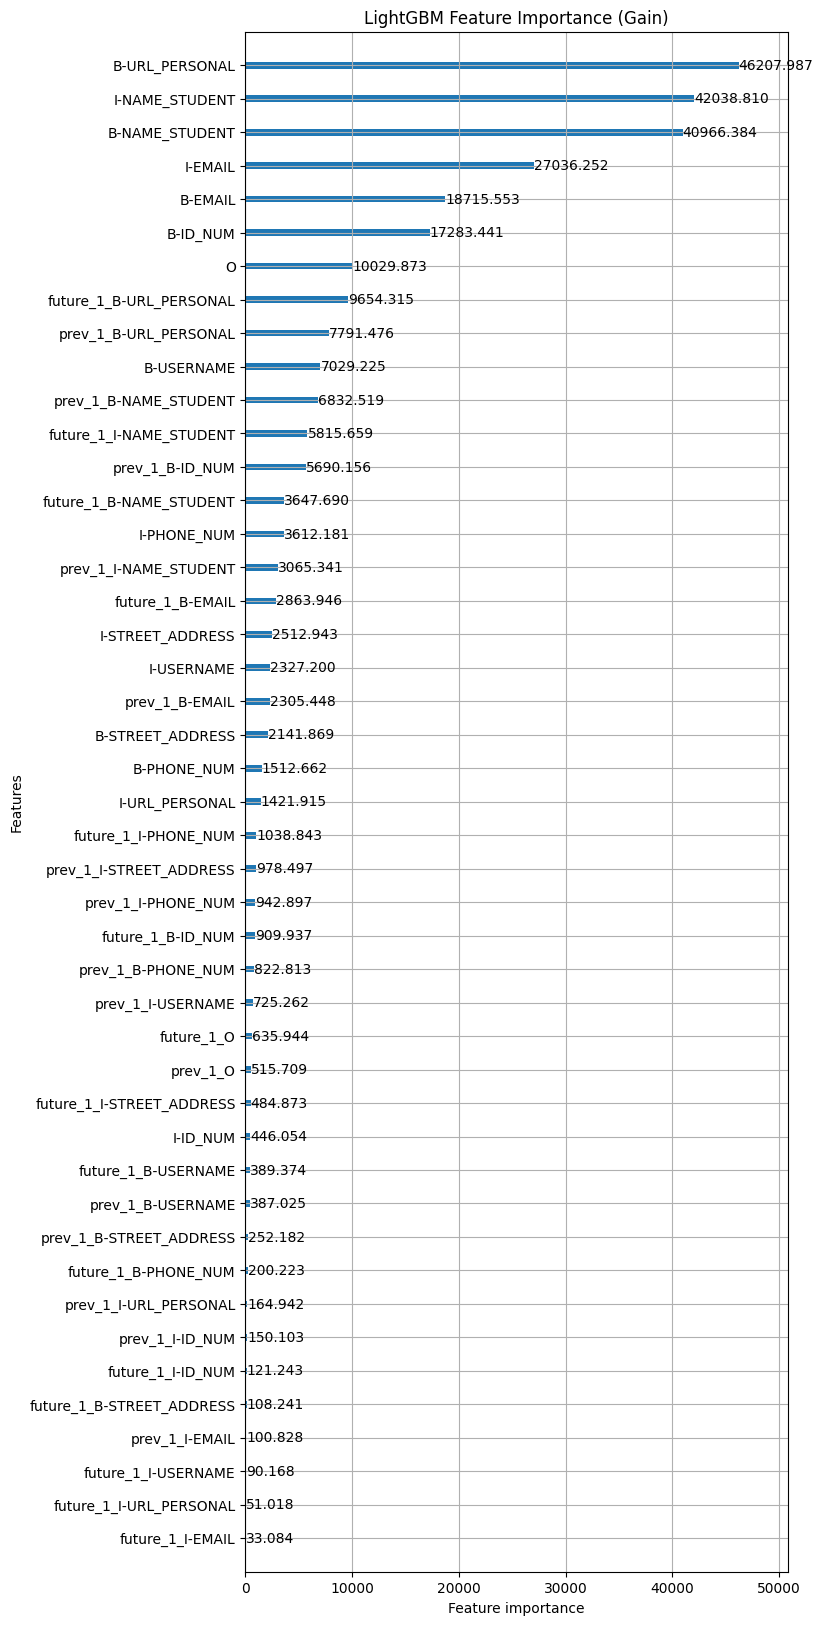

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, importance_type="gain", figsize=(7,20), title="LightGBM Feature Importance (Gain)")
plt.show()
plt.tight_layout()

In [25]:
y_valid_pred = model.predict(X_valid)

In [26]:
valid_valid_dataset = valid_dataset.filter(
    lambda example: example["document"] in valid_df["document"].tolist()
)

Filter:   0%|          | 0/473 [00:00<?, ? examples/s]

In [27]:
valid_valid_dataset

Dataset({
    features: ['full_text', 'trailing_whitespace', 'provided_labels', 'tokens', 'document', 'flag', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'length', 'token_map'],
    num_rows: 120
})

In [28]:
from tqdm.auto import tqdm
all_token = []
documents = []
deberta_token_num = []
for full_text, offset_mapping, document in tqdm(
    zip(
        valid_valid_dataset["full_text"],
        valid_valid_dataset["offset_mapping"],
        valid_valid_dataset["document"],
    ),
    total = len(valid_valid_dataset)
):
    for token_num, (start_idx, end_idx) in enumerate(offset_mapping):
        all_token.append(full_text[start_idx:end_idx])
        documents.append(document)
        deberta_token_num.append(token_num)

  0%|          | 0/120 [00:00<?, ?it/s]

In [29]:
valid_pred_df = pd.DataFrame(
    {
        "document": documents,
        "deberta_token_num": deberta_token_num,
        "text": all_token,
        "y_valid": [id2label[val] for val in y_valid],
        "y_valid_pred": [id2label[val] for val in y_valid_pred.argmax(axis=1)],
        "y_valid_ensemble": [id2label[val] for val in valid_df[TAG_NAMES].values.argmax(-1)]
    }
)

In [30]:
from sklearn.metrics import classification_report

print(
    classification_report(valid_pred_df["y_valid"].tolist(), valid_pred_df["y_valid_pred"].tolist())
)

print(
    classification_report(valid_pred_df["y_valid"].tolist(), valid_pred_df["y_valid_ensemble"].tolist())
)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

                precision    recall  f1-score   support

       B-EMAIL       1.00      1.00      1.00        48
      B-ID_NUM       0.94      0.98      0.96        91
B-NAME_STUDENT       0.85      1.00      0.92       230
B-URL_PERSONAL       0.77      1.00      0.87       259
    B-USERNAME       0.00      0.00      0.00         0
I-NAME_STUDENT       0.93      1.00      0.96       200
I-URL_PERSONAL       0.00      0.00      0.00         7
             O       1.00      1.00      1.00    100824

      accuracy                           1.00    101659
     macro avg       0.69      0.75      0.71    101659
  weighted avg       1.00      1.00      1.00    101659



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

                precision    recall  f1-score   support

       B-EMAIL       1.00      1.00      1.00        48
      B-ID_NUM       1.00      0.89      0.94        91
B-NAME_STUDENT       0.92      1.00      0.96       230
B-URL_PERSONAL       0.79      1.00      0.88       259
    B-USERNAME       0.00      0.00      0.00         0
I-NAME_STUDENT       0.98      0.99      0.99       200
I-URL_PERSONAL       0.00      0.00      0.00         7
             O       1.00      1.00      1.00    100824

      accuracy                           1.00    101659
     macro avg       0.71      0.73      0.72    101659
  weighted avg       1.00      1.00      1.00    101659



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f6dfc18c4360bbe4f09b5d84ac967a3b19d0ebf2acc1ffebb9e5d358476bbdf5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [32]:
from seqeval.metrics.sequence_labeling import precision_recall_fscore_support

cv_score = precision_recall_fscore_support(
    [valid_pred_df["y_valid"].tolist()],
    [valid_pred_df["y_valid_ensemble"].to_list()],
    beta=5,
    average="micro",
)[2]

print(f"Ensemble f5score CV:{cv_score}")

cv_score = precision_recall_fscore_support(
    [valid_pred_df["y_valid"].tolist()],
    [valid_pred_df["y_valid_pred"].to_list()],
    beta=5,
    average="micro",
)[2]

print(f"LightGBM f5score CV:{cv_score}")

Ensemble f5score CV:0.9741683928353845
LightGBM f5score CV:0.9862613981762918


In [33]:
valid_pred_df.to_csv("valid_pred.csv", index=False)

In [34]:
valid_pred_df[
    valid_pred_df["y_valid"] != valid_pred_df["y_valid_pred"]
]

,document,deberta_token_num,text,y_valid,y_valid_pred,y_valid_ensemble
20,2915,20,Carolina,O,B-NAME_STUDENT,B-NAME_STUDENT
21,2915,21,Gomez,O,I-NAME_STUDENT,I-NAME_STUDENT
1281,6853,264,George,O,B-NAME_STUDENT,O
1283,6853,266,Geoff,O,B-NAME_STUDENT,O
6702,379,37,In,O,B-URL_PERSONAL,O
...,...,...,...,...,...,...
94296,9585,766,Michelle,O,B-NAME_STUDENT,B-NAME_STUDENT
94539,9585,1009,Michelle,O,B-NAME_STUDENT,B-NAME_STUDENT
94564,9585,1034,Michelle,O,B-NAME_STUDENT,B-NAME_STUDENT
94699,9146,98,n,B-ID_NUM,B-USERNAME,B-USERNAME


In [35]:
import pickle
with open("trained_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [36]:
!rm -rf /kaggle/working/valid_dataset